In [9]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from joblib import Parallel, delayed
from skimage import (
    color,
    exposure,
    feature,
    filters,
    measure,
    morphology,
    segmentation,
    util,
)
from tqdm.notebook import tqdm
import joblib

In [3]:
props = [
    "area",
    "area_bbox",
    "area_convex",
    "axis_major_length",
    "axis_minor_length",
    "bbox",
    "centroid_local",
    "centroid_weighted_local",
    "eccentricity",
    "equivalent_diameter_area",
    "extent",
    "feret_diameter_max",
    "inertia_tensor_eigvals",
    # "intensity_max",
    # "intensity_mean",
    # "intensity_min",
    # "intensity_std",
    "label",
    "moments",
    "moments_central",
    "moments_hu",
    "moments_normalized",
    "moments_weighted",
    "moments_weighted_central",
    "moments_weighted_hu",
    "moments_weighted_normalized",
    # "num_pixels",
    # "orientation",
    "perimeter",
    "perimeter_crofton",
    "solidity",
]


def seg_analysis(properties, seg, image, spacing=(1, 1)):
    props_df = measure.regionprops_table(
        seg,
        intensity_image=image,
        properties=props,
        spacing=spacing,
    )
    props_df = pd.DataFrame(props_df)
    return props_df


def is_in_worm(region_mask, worm_seg):
    return np.any(worm_seg[region_mask] > 0)


def preprocess_worm_seg(seg):
    min_size = 500
    new_seg = np.zeros_like(seg)

    connected_components = measure.label(seg > 0)
    joint_seg = segmentation.join_segmentations(
        seg, connected_components, return_mapping=False
    )

    for region in measure.regionprops(joint_seg):
        if region.num_pixels <= min_size:
            continue
        ys, xs = region.coords.T
        mask = np.zeros_like(seg, dtype=bool)
        mask[ys, xs] = True
        mask = morphology.isotropic_erosion(mask, radius=5)

        new_seg[mask] = seg[mask]
    return new_seg


def semantic_seg(egg_seg, worm_seg):
    properties = ["label"]
    extra_properties = [is_in_worm]

    props_table = measure.regionprops_table(
        egg_seg, worm_seg, properties=properties, extra_properties=extra_properties
    )
    props_df = pd.DataFrame(props_table)
    props_df["class"] = props_df["is_in_worm"].apply(
        lambda x: "egg" if not x else "other"
    )
    props_df = props_df.drop(columns=["is_in_worm"])
    return props_df


def process_row(row):
    time = row["Time"]
    point = row["Point"]
    egg_seg_file = row["stardist_seg"]
    worm_seg_file = row["manual_seg"]
    raw_file = row["training_image"]

    egg_seg = tifffile.imread(egg_seg_file)
    worm_seg = tifffile.imread(worm_seg_file)
    worm_seg = preprocess_worm_seg(worm_seg)

    raw = tifffile.imread(raw_file)

    props_df = seg_analysis(
        props,
        egg_seg,
        raw,
        spacing=(1, 1),
    )

    semantic_df = semantic_seg(egg_seg, worm_seg)

    combined_df = props_df.merge(semantic_df, on="label", how="outer")
    combined_df["Time"] = time
    combined_df["Point"] = point
    return combined_df

In [4]:
filemap = pd.read_csv(
    "/mnt/towbin.data/shared/bgusev/stardist_egg_seg/xgboost_training/training_data/filemap.csv"
)
filemap.head()

,Time,Point,raw,training_image,manual_seg,_raw_local,stardist_seg
0,1,15,/mnt/towbin.data/shared/smarin/data/2024_02_07...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...
1,1,31,/mnt/towbin.data/shared/smarin/data/2024_02_07...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...
2,2,7,/mnt/towbin.data/shared/smarin/data/2024_02_07...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...
3,2,42,/mnt/towbin.data/shared/smarin/data/2024_02_07...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...
4,3,37,/mnt/towbin.data/shared/smarin/data/2024_02_07...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...,/mnt/towbin.data/shared/bgusev/stardist_egg_se...


In [5]:
features_df = Parallel(n_jobs=-1)(
    delayed(process_row)(row) for _, row in tqdm(filemap.iterrows(), total=len(filemap))
)
features_df = pd.concat(features_df, axis=0)
print(features_df.shape)
features_df.head()

  0%|          | 0/597 [00:00<?, ?it/s]

(93911, 136)


,area,area_bbox,area_convex,axis_major_length,axis_minor_length,bbox-0,bbox-1,bbox-2,bbox-3,centroid_local-0,...,moments_weighted_normalized-3-0,moments_weighted_normalized-3-1,moments_weighted_normalized-3-2,moments_weighted_normalized-3-3,perimeter,perimeter_crofton,solidity,class,Time,Point
0,498.0,667.0,521.0,28.438778,22.348920,1592,958,1621,981,13.387550,...,0.002327,-0.000483,0.000055,-0.000021,84.426407,82.722770,0.955854,egg,1,15
1,3739.0,4920.0,3872.0,127.288747,38.265971,1457,1580,1497,1703,20.815191,...,-0.000055,0.000026,-0.000003,0.000002,291.681241,279.212674,0.965651,other,1,15
2,464.0,648.0,487.0,28.912659,20.528012,1297,1583,1321,1610,11.148707,...,-0.000601,-0.001563,0.000009,-0.000182,81.012193,79.485892,0.952772,egg,1,15
3,487.0,780.0,517.0,34.987935,17.822422,1462,495,1492,521,14.347023,...,-0.001896,0.006149,-0.000119,0.000645,90.083261,88.871202,0.941973,egg,1,15
4,199.0,270.0,212.0,17.326466,14.701623,980,1406,998,1421,8.115578,...,0.002410,-0.001219,-0.000024,-0.000107,52.041631,52.020077,0.938679,egg,1,15


In [6]:
groups = list(iter(features_df.groupby(["Time", "Point"])))

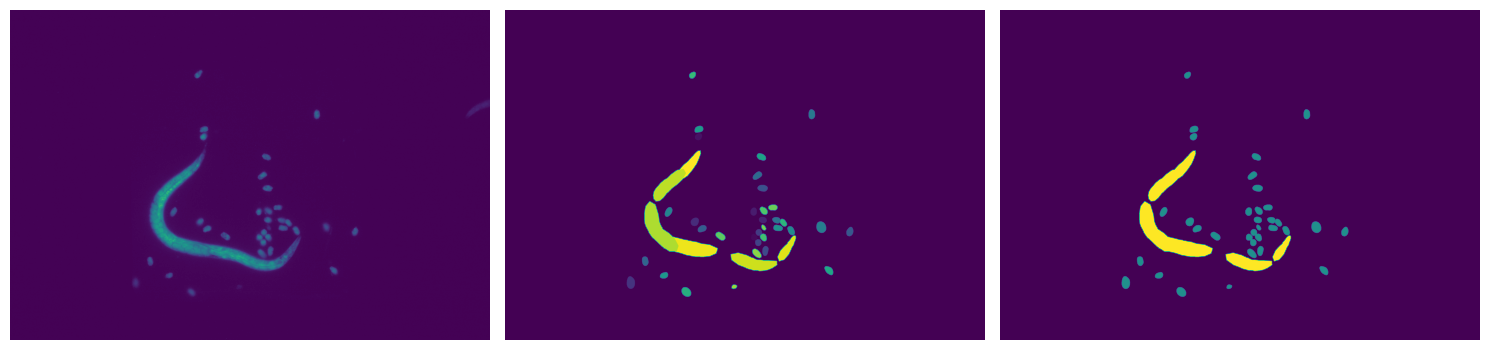

In [7]:
idx = np.random.randint(0, len(groups))
(time, point), random_group = groups[idx]

raw_img = filemap.query(f"Time == {time} and Point == {point}")[
    "training_image"
].values[0]
raw_img = tifffile.imread(raw_img)
seg_img = filemap.query(f"Time == {time} and Point == {point}")["stardist_seg"].values[
    0
]
seg_img = tifffile.imread(seg_img)
instance_labels = random_group["label"].values
semantic_labels = random_group["class"].map({"egg": 1, "other": 2}).values
semantic_img = util.map_array(seg_img, instance_labels, semantic_labels)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
[ax.axis("off") for ax in axs]
[ax.imshow(img) for ax, img in zip(axs, [raw_img, seg_img, semantic_img])]
fig.tight_layout()

# (time, point), random_group

In [8]:
features_df.to_csv("training_data/seg_features.csv", index=False)

In [10]:
joblib.dump(props, "egg_classifier_models/props.joblib.pkl")

['egg_classifier_models/props.joblib.pkl']